# 순환신경망 6
> LSTM (2) - LSTM의 계산과정, LSTM은 왜 강한가?

# import

In [37]:
import torch
import matplotlib.pyplot as plt

# Define some functions

In [38]:
def f(txt, mapping):
    return [mapping[key] for key in txt]
    
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

# LSTM의 계산과정

## data: abaB

In [39]:
txt = list('abaB')*100
txt[:5]

['a', 'b', 'a', 'B', 'a']

In [40]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [41]:
mapping = {'a':0, 'b':1, 'B':2}
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

## 1 epoch ver1 (with torch.nn.LSTMCell)

In [42]:
torch.manual_seed(43052)
lstm_cell = torch.nn.LSTMCell(3,2) # hidden node: 2
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm_cell.parameters()) + list(linr.parameters()), lr=0.1)

In [43]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht,ct = lstm_cell(xt,(ht,ct))
        ot = linr(ht) 
        loss = loss + loss_fn(ot,yt)
    loss = loss / T
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [44]:
ht, ct

(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))

## 1 epoc ver2 (완전 손으로 구현)

### $t=0 \to t=1$

`-` lstm_cell을 이용한 계산 (결과비교용)

In [45]:
torch.manual_seed(43052)
lstm_cell = torch.nn.LSTMCell(3,2)
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm_cell.parameters()) + list(linr.parameters()), lr=0.1)

In [46]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(1):
        xt,yt = x[[t]], y[[t]]
        ht,ct = lstm_cell(xt,(ht,ct))
    #     ot = linr(ht) 
    #     loss = loss + loss_fn(ot,yt)
    # loss = loss / T
    # ## 3 
    # loss.backward()
    # ## 4 
    # optimizr.step()
    # optimizr.zero_grad()

In [47]:
ht, ct

(tensor([[-0.0541,  0.0892]], grad_fn=<MulBackward0>),
 tensor([[-0.1347,  0.2339]], grad_fn=<AddBackward0>))

- 이런결과를 어떻게 만드는걸가?

- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html


$$\begin{align*}i_t & = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1}+b_{hi}) \\
f_t & = \sigma(W_{if}x_t + b_{if} +W_{hf}h_{t-1}+b_{hf}) \\
g_t & = \text{tanh} (W_{ig}x_t + b_{ig} + W_{hg}h_{t-1}+b_{hg} \\
o_t & = \sigma(W_{io}x_t + b_{io}+W_{ho}h_{t-1} +b_{ho}) \\
c_t & = f_t\odot c_{t-1} + i_t \odot g_t \\
h_t &= o_t \odot \text{tanh}(c_t)
\end{align*}$$

- $h_t$: hidden state at $t$
- $c_t$: cell state at time $t$
- $x_t$: the input at time $t$
- $h_{t-1}$: the hidden state of the layer at time $t-1$
- $i_t, f_t, g_t, o_t$: input,forget,cell,and output gates, respectively
- $\sigma$: the sigmoid function
- $\odot$: the Hadamard product

- (참고) $\odot$ : elment-wise 하게 곱하는 연산자
    - $(1,2) \odot (3,0) = (3,0)$

`-` 직접계산

In [48]:
ht = torch.zeros(1,2)
ct = torch.zeros(1,2)

$$(x_t, h_{t-1}) \overset{lin}{\to} [a,b,c,d] \to [\sigma(a), \sigma(b),\text{tanh}(c),\sigma(d)] = [i_t,f_t,g_t,o_t]$$

In [49]:
_ifgo = xt @ lstm_cell.weight_ih.T + ht @ lstm_cell.weight_hh.T + lstm_cell.bias_ih + lstm_cell.bias_hh
_ifgo

tensor([[ 0.0728,  0.1561,  0.0693,  0.5941, -0.2661,  0.4648, -0.3884, -0.4536]],
       grad_fn=<AddBackward0>)

In [50]:
input_gate = sig(_ifgo[:,0:2])
forget_gate = sig(_ifgo[:,2:4])
gt = tanh(_ifgo[:,4:6])
output_gate = sig(_ifgo[:,6:8])

In [51]:
ct = forget_gate * ct + input_gate * gt
ht = output_gate * tanh(ct)

In [52]:
ht,ct

(tensor([[-0.0541,  0.0892]], grad_fn=<MulBackward0>),
 tensor([[-0.1347,  0.2339]], grad_fn=<AddBackward0>))

### $t=0 \to t=T$

In [53]:
torch.manual_seed(43052) 
lstm_cell = torch.nn.LSTMCell(3,2) 
linr = torch.nn.Linear(2,3)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm_cell.parameters())+list(linr.parameters()),lr=0.1)

In [54]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0 
    ## 1~2
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        
        ## lstm_cell step1: calculate _ifgo 
        _ifgo = xt @ lstm_cell.weight_ih.T + ht @ lstm_cell.weight_hh.T + lstm_cell.bias_ih + lstm_cell.bias_hh
        ## lstm_cell step2: decompose _ifgo 
        input_gate = sig(_ifgo[:,0:2])
        forget_gate = sig(_ifgo[:,2:4])
        gt = tanh(_ifgo[:,4:6])
        output_gate = sig(_ifgo[:,6:8])
        ## lstm_cell step3: calculate ht,ct 
        ct = forget_gate * ct + input_gate * gt
        ht = output_gate * tanh(ct)
        
    #     ot = linr(ht) 
    #     loss = loss + loss_fn(ot,yt)
    # loss = loss / T
    # ## 3 
    # loss.backward()
    # ## 4 
    # optimizr.step()
    # optimizr.zero_grad()

In [55]:
ht,ct

(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))

```
(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))
 ```

# 1 epoch ver3 (with torch.nn.LSTM)

In [56]:
torch.manual_seed(43052)
lstm_cell = torch.nn.LSTMCell(3,2)
linr = torch.nn.Linear(2,3)

In [57]:
lstm = torch.nn.LSTM(3,2)

In [58]:
lstm.weight_hh_l0.data = lstm_cell.weight_hh.data 
lstm.bias_hh_l0.data = lstm_cell.bias_hh.data 
lstm.weight_ih_l0.data = lstm_cell.weight_ih.data 
lstm.bias_ih_l0.data = lstm_cell.bias_ih.data

In [59]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters()) + list(linr.parameters()), lr=0.1) 

In [60]:
_water = torch.zeros(1,2) 
for epoc in range(1): 
    ## step1 
    hidden, (ht,ct) = lstm(x,(_water,_water))
    output = linr(hidden)
    # ## step2
    # loss = loss_fn(output,y) 
    # ## step3
    # loss.backward()
    # ## step4 
    # optimizr.step()
    # optimizr.zero_grad() 

In [62]:
ht, ct

(tensor([[-0.0406,  0.2505]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.0975,  0.7134]], grad_fn=<SqueezeBackward1>))

# LSTM은 왜 강한가?

## data: abaB

In [63]:
txt = list('abaB')*100
txt[:5]

['a', 'b', 'a', 'B', 'a']

In [64]:
n_words = 3

In [65]:
mapping = {'a':0,'b':1,'B':2}

In [66]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [67]:
txt_x[:10], txt_y[:10]

(['a', 'b', 'a', 'B', 'a', 'b', 'a', 'B', 'a', 'b'],
 ['b', 'a', 'B', 'a', 'b', 'a', 'B', 'a', 'b', 'a'])

In [68]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [69]:
x,y

(tensor([[1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [0., 1., 0.],
         [1., 0., 0.]]),
 tensor([[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.],
         ...,
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]]))

## 1000 epoch

In [70]:
torch.manual_seed(43052) 
lstm = torch.nn.LSTM(3,2) 
linr = torch.nn.Linear(2,3) 

In [71]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm.parameters())+ list(linr.parameters()),lr=0.1)

In [72]:
_water = torch.zeros(1,2) 
for epoc in range(1000): 
    ## step1 
    hidden, (ht,ct) = lstm(x,(_water,_water))
    output = linr(hidden)
    ## step2
    loss = loss_fn(output,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

## 시각화

In [73]:
T = len(x)
input_gate = torch.zeros(T,2)
forget_gate = torch.zeros(T,2)
output_gate = torch.zeros(T,2)
g = torch.zeros(T,2)
cell = torch.zeros(T,2)
h = torch.zeros(T,2) 

In [75]:
for t in range(T): 
    ## 1: calculate _ifgo 
    _ifgo = x[[t]] @ lstm.weight_ih_l0.T + h[[t]] @ lstm.weight_hh_l0.T + lstm.bias_ih_l0 + lstm.bias_hh_l0 
    ## 2: decompose _ifgo 
    input_gate[[t]] = sig(_ifgo[:,0:2])
    forget_gate[[t]] = sig(_ifgo[:,2:4])
    g[[t]] = tanh(_ifgo[:,4:6])
    output_gate[[t]] = sig(_ifgo[:,6:8])
    ## 3: calculate ht,ct 
    cell[[t]] = forget_gate[[t]] * cell[[t]] + input_gate[[t]] * g[[t]]
    h[[t]] = output_gate[[t]] * tanh(cell[[t]])

In [76]:
combinded1 = torch.concat([input_gate,forget_gate,output_gate],axis=1)
combinded2 = torch.concat([g,cell,h,soft(output)],axis=1)

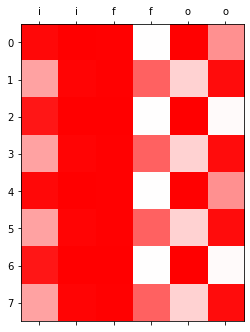

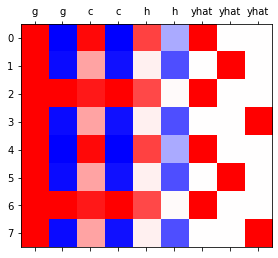

In [77]:
plt.matshow(combinded1[-8:].data,cmap='bwr',vmin=-1,vmax=1);
plt.xticks(range(combinded1.shape[-1]),labels=['i']*2 + ['f']*2 + ['o']*2);
plt.matshow(combinded2[-8:].data,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(combinded2.shape[-1]),labels=['g']*2 + ['c']*2 + ['h']*2 + ['yhat']*3);

- 상단그림은 게이트의 값들만 시각화, 하단그림은 게이트 이외의 값들을 시각화

## 시각화의 해석 I

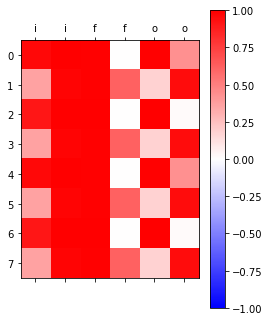

In [80]:
plt.matshow(combinded1[-8:].data,cmap='bwr',vmin=-1,vmax=1);
plt.xticks(range(combinded1.shape[-1]),labels=['i']*2 + ['f']*2 + ['o']*2);
plt.colorbar()

`-` input gate, forget gate, output_gate는 모두 $0\sim 1$ 사이의 값을 가진다.

- (참고) 파:$-1$, 흰:$0$, 빨:$1$

`-` 이 값들은 각각 모두 $g_t, c_{t-1}, \text{tanh}(c_t)$ 에 곱해진다. 따라서 input_gate, forget_fate, ouput_gate는 gate의 역할로 비유가능하다. **(1이면 통과, 0이면 차단)**

- input_gate: $g_t$ 의 값을 얼만큼 통과시킬지 $0\sim 1$ 사이의 숫자로 결정
- forget_gate: $c_{t-1}$의 값을 얼만큼 통과시킬지 $0\sim 1$ 사이의 숫자로 결정
- output_gate: $\text{htan}(c_t)$ 의 값들을 얼만큼 통과시킬지 $0\sim 1$ 사이의 숫자로 결정

*input/forget/output gate가 진짜 문지기 같은 역할을 함 (어떤 값을 통과시킬지 말지 0과 1사이의 숫자로 정해주는 역할을 한다.) 그렇기 때문에 gate라는 이름이 붙게 되었다.*

## 시각화의 해석 II

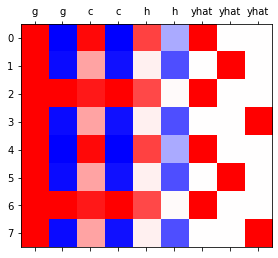

In [79]:
plt.matshow(combinded2[-8:].data,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(range(combinded2.shape[-1]),labels=['g']*2 + ['c']*2 + ['h']*2 + ['yhat']*3);

`-` 결국 $g_t \to c_t \to h_t \to \hat{y}$의 느낌이다. ($h_t$를 계산하기 위해서는 $c_t$가 필요했고, $c_t$를 계산하기 위해서는 $c_{t-1}$ 과 $g_t$가 필요했음)

- $h_t = \text{tanh}(c_t) \odot o_t$
- $c_t = c_{t-1} \odot f_t + g_t \odot i_t$

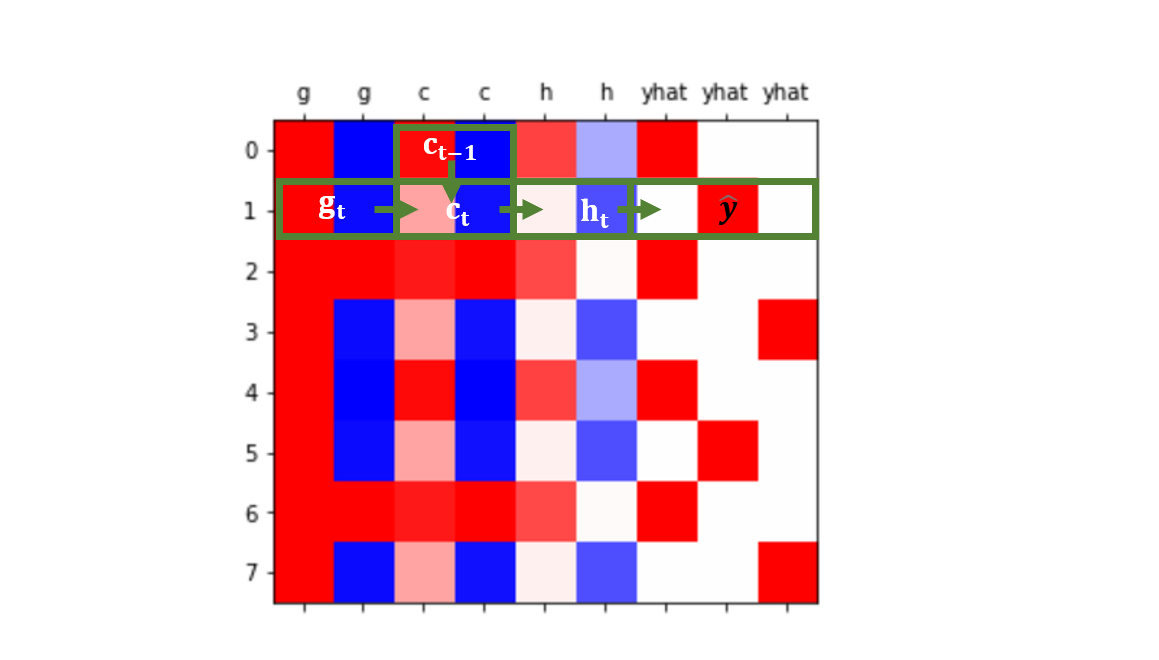

`-` $g_t, c_t, h_t$ 모두 $x_t$의 정보를 숙성시켜 가지고 있는 느낌이 든다.

`-` $g_t$의 특징: 보통 -1, 1 중 하나의 값을 가지도록 학습되어 있다. (마치 RNN의 hidden node처럼!)

- $g_t = \text{tanh}(x_t\bf{W}_{ig}+h_{t-1}\bf{W}_{hg}+b_{ig}+b_{hg})$

`-` $c_t$의 특징: $g_t$와 매우 비슷하지만 약간 다른 값을 가진다. 그래서 $g_t$와 달리 $-1,1$ 이외의 값도 종종 등장.

- ***$g_t, c_t, h_t$ 모두 콩물($x_t$)를 숙성시킨 간장이지만 $g_t$ 보다는 $c_t$가 더, $h_t$보다는 $c_t$가 더 숙성된 느낌이다.***
- ***$g_t$는 진한 빨/파 였다면 $c_t$는 $g_t$와 유사하지만 좀 더 연한 빨/파, $h_t$는 $c_t$와 유사하지만 더 연한 빨/파***

In [82]:
print("first row: gt={}, ct={}".format(g[-8].data, cell[-8].data))
print("second row: gt={}, ct={}".format(g[-7].data, cell[-7].data))
#g[-7], cell[-7]

first row: gt=tensor([ 0.9999, -0.9999]), ct=tensor([ 0.9647, -0.9984])
second row: gt=tensor([ 0.9970, -0.9554]), ct=tensor([ 0.3592, -0.9373])


`-` $h_t$의 특징: (1) $c_t$의 느낌이 있음 하지만 약간의 변형이 있음. (2) -1~1 사이의 값을 훨씬 다양하게 가진다. (tanh때문)

In [83]:
print("first row: gt={}, ct={}, ht={}".format(g[-8].data, cell[-8].data,h[-8].data))
print("second row: gt={}, ct={}, ht={}".format(g[-7].data, cell[-7].data,h[-7].data))
#g[-7], cell[-7]

first row: gt=tensor([ 0.9999, -0.9999]), ct=tensor([ 0.9647, -0.9984]), ht=tensor([ 0.7370, -0.3323])
second row: gt=tensor([ 0.9970, -0.9554]), ct=tensor([ 0.3592, -0.9373]), ht=tensor([ 0.0604, -0.6951])


`-` 예전의문 해결

- 실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.

- 그 이유: RNN은 $h_t$의 값이 $-1$ 혹은 $1$로 결정되는 경우가 많았음. 그러나 경우에 따라서는 $h_t$이 -1~1의 값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한다 LSTM이 이러한 방식으로 학습되는 경우가 많았음.
- 왜 LSTM의 $h_t$은 -1,1 이외의 값을 쉽게 가질 수 있는가? (1) gate들의 역할 (2) 마지막에 취해지는 tanh때문

## LSTM의 알고리즘 리뷰 I (수식위주)

**(step1)** calculate $\tt{ifgo}$

${\tt ifgo} = {\boldsymbol x}_t \big[{\bf W}_{ii} | {\bf W}_{if}| {\bf W}_{ig} |{\bf W}_{io}\big] + {\boldsymbol h}_{t-1} \big[ {\bf W}_{hi}|{\bf W}_{hf} |{\bf W}_{hg} | {\bf W}_{ho} \big] + bias \\
 =\big[{\boldsymbol x}_t{\bf W}_{ii} + {\boldsymbol h}_{t-1}{\bf W}_{hi} ~\big|~ {\boldsymbol x}_t{\bf W}_{if}+ {\boldsymbol h}_{t-1}{\bf W}_{hf}~ \big|~ {\boldsymbol x}_t{\bf W}_{ig} + {\boldsymbol h}_{t-1}{\bf W}_{hg} ~\big|~ {\boldsymbol x}_t{\bf W}_{io} + {\boldsymbol h}_{t-1}{\bf W}_{ho} \big] + bias$

참고: 위의 수식은 아래코드에 해당하는 부분

In [84]:
ifgo = xt @ lstm_cell.weight_ih.T +\
       ht @ lstm_cell.weight_hh.T +\
       lstm_cell.bias_ih + lstm_cell.bias_hh

**(stpe2)** decompose $\tt{ifgo}$ and get $i_t,f_t,g_t,o_t$

${\boldsymbol i}_t = \sigma({\boldsymbol x}_t {\bf W}_{ii} + {\boldsymbol h}_{t-1} {\bf W}_{hi} +bias ) \\
{\boldsymbol f}_t = \sigma({\boldsymbol x}_t {\bf W}_{if} + {\boldsymbol h}_{t-1} {\bf W}_{hf} +bias ) \\
{\boldsymbol g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg} +bias ) \\
{\boldsymbol o}_t = \sigma({\boldsymbol x}_t {\bf W}_{io} + {\boldsymbol h}_{t-1} {\bf W}_{ho} +bias )$

**(step3)** calculate $c_t$ and $h_t$

${\boldsymbol c}_t = {\boldsymbol i}_t \odot {\boldsymbol g}_t+ {\boldsymbol f}_t \odot {\boldsymbol c}_{t-1} \\
{\boldsymbol h}_t = \tanh({\boldsymbol o}_t \odot {\boldsymbol c}_t)$

## LSTM의 알고리즘 리뷰 II (느낌위주)

> 이해 및 암기를 돕기위해서 비유적으로 설명한 챕터!

`-` 느낌1: RNN이 콩물에서 간장을 한번에 숙성시키는 방법이라면 LSTM은 콩물에서 간장을 3차로 나누어 숙성하는 느낌이다.

- 콩물: $\boldsymbol x_t$
- 1차숙성: $\boldsymbol g_t$
- 2차숙성: $\boldsymbol c_t$
- 3차숙성: $\boldsymbol h_t$

`-` 느낌2: $g_t$ 에 대하여

- 계산방법: $x_t$와 $h_{t-1}$를 $\bf{W}_{ig},\bf{W}_{hg}$를 이용해 선형결합하고 $\tt{tanh}$를 취한결과
- RNN에서 간장을 만들던 그 수식에서 $h_t$를 $g_t$ 로 바꾼것.
- 크게 2가지의 의미를 가진다. (1) 과거와 현재의 결합 (2) 활성화함수 $\text{tanh}$ 를 적용

`-` 느낌3: $\boldsymbol c_t$ 에 대하여 (1)

- 계산방법: $g_t$와 $c_{t-1}$을 요소별로 선택하고 더하는 과정
- $g_t$는 (1) 과거와 현재의 결합 (2) 활성화함수 tanh를 적용으로 나누어지는데 이중에서 (1) 과거와 현재의 정보를 결합하는 과정만 해당한다. 차이점은 요소별 선택 후 덧셈
- 이러한 결합을 쓰는 이유? 게이트를 이용하여 과거와 현재의 정보를 제어 (일반적인 설명)

`-` 느낌4: $\boldsymbol c_t$에 대하여 (2) // $\boldsymbol c_t$는 왜 과거와 현재의 정보를 제어한다고 볼 수 있는가?

$t=1$ 시점 계산과정관찰

In [85]:
input_gate[1],g[1], forget_gate[1], cell[0]

(tensor([0.9065, 0.9999], grad_fn=<SelectBackward0>),
 tensor([0.9931, 0.9999], grad_fn=<SelectBackward0>),
 tensor([0.9931, 0.0014], grad_fn=<SelectBackward0>),
 tensor([ 0.3592, -0.9373], grad_fn=<SelectBackward0>))

$[0.9,1.0]\odot \boldsymbol g_t + [1.0,0.0] \odot \boldsymbol c_{t-1}$

- forget_gate는 $c_{t-1}$의 첫번째 원소는 기억하고, 두번째 원소는 잊으라고 말하고 있음 // forget_gate는 과거($c_{t-1})$의 정보를 얼마나 잊을지 (=얼마나 기억할지)를 결정한다고 해석할 수 있다.
- input_gate는 $\boldsymbol g_t$의 첫번째 원소와 두 번째 원소를 모두 기억하되 두번째 원소를 좀 더 중요하게 기억하라고 말하고 있음 // input_gate는 현재($\boldsymbol g_t$)

- 이 둘을 조합하면 $\boldsymbol c_t$가 현재와 과거의 정보중 어떠한 정보를 중시하면서 기억할지 결정한다고 볼 수 있다.

`-` 느낌5: $\boldsymbol c_t$에 대하여 (3)

- 사실상  LSTM 알고리즘의 꽃이라 할 수 있음.
- LSTM은 long short term memory의 약자임. 기존의 RNN은 장기기억을 활용함에 약점이 있는데 LSTM은 단기기억/장기기억 모두 잘 활용함.
- LSTM이 장기기억을 잘 활용하는 비법은 바로 $c_t$에 있다.

`-` 느낌6: $\boldsymbol h_t$에 대하여 - 계산방법: $\text{tanh}(c_t)$를 요소별로 선택

`-` RNN, LSTM의 변수들 비교 테이블

||과거정보|현재정보|과거와 현재의 결합방식|활성화|느낌|비고|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|RNN-${\boldsymbol h}_t$|${\boldsymbol h}_{t-1}$|${\boldsymbol x}_t$|$\times$ $\to$ $+$|$\tanh$|간장|
|LSTM-${\boldsymbol g}_t$|${\boldsymbol h}_{t-1}$|${\boldsymbol x}_t$|$\times$ $\to$ $+$|$\tanh$|1차간장|
|LSTM-${\boldsymbol c}_t$|${\boldsymbol c}_{t-1}$|${\boldsymbol g}_t$|$\odot$ $\to$ $+$ |None|2차간장|gate를 열림정도를 판단할때 ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$을 이용|
|LSTM-${\boldsymbol h}_t$|None|${\boldsymbol c}_t$|None|$\tanh$, $\odot$|3차간장|gate를 열림정도를 판단할때 ${\boldsymbol x}_t$와 ${\boldsymbol h}_{t-1}$을 이용|

- RNN은 기억할 과거정보가 $h_{t-1}$ 하나이지만 LSTM은 $\boldsymbol c_{t-1}, \boldsymbol h_{t-1}$ 2개이다.

`-` 알고리즘리뷰:

- 콩물, 과거 3차간장 $\overset{\text{x},+,\text{tanh}} \longrightarrow$ 현재1차간장
- 현재1차간장, 과거2차간장 $\overset{\odot,+,\text{tanh}} \longrightarrow$ 현재 2차간장
- 현재2차간장 $\overset{\text{tanh},\odot}\longrightarrow$ 현재 3차간장

## LSTM이 강한 이유

`-` LSTM이 장기기억에 유리함. 그 이유는 input, forget, output gate들이 과거기억을 위한 역할을 하기 때문.

- 비판: 아키텍처에 대한 이론적 근거는 없음. 장기기억을 위하여 꼭 LSTM같은 구조일 필요는 없음. (왜 3차간장을 만들때 tanh를 써야하는지? 게이트는 꼭 3개이어야 하는지?)

- 실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.
- 그 이유: RNN은 $\boldsymbol h_t$의 값이 -1 혹은 1로 결정되는 경우가 많았음. 그러나 경우에 따라서는 $\boldsymbol h_t$이 -1 ~ 1의 값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한데 LSTM이 이러한 방식으로 학습되는 경우가 많았음.
- 왜 LSTM은 $\boldsymbol h_t$은 -1,1 이외의 값을 쉽게 가질 수 있는가? (1) gate들의 역할 (2) 마지막에 취해지는 tanh 때문

## 참고자료들

- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://arxiv.org/abs/1402.1128